In [2]:
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
import numpy as np
from sklearn import tree
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from numpy import set_printoptions
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from statistics import mean
from sklearn.metrics import plot_confusion_matrix
import shap

In [3]:
df = pd.read_csv("data.csv")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [4]:
df.describe()

,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


The data has both numerical and categorical data which means we have to encode categorical data before using ML algorithms

In [6]:
# using label encoder for 'y' output
label_encoder = LabelEncoder()

In [7]:
df['y']= label_encoder.fit_transform(df['y'])
 
df['y'].unique()

array([0, 1])

In [8]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,technician,married,tertiary,no,395,no,no,cellular,3,jun,107,1,0
39996,30,management,single,tertiary,no,3340,no,no,cellular,3,jun,238,3,1
39997,54,admin,divorced,secondary,no,200,no,no,cellular,3,jun,170,1,1
39998,34,management,married,tertiary,no,1047,no,no,cellular,3,jun,342,1,0


In [9]:
# using One Hot Encoder for features 'job','marital','education','default','housing','loan','contact','month'
one_hot_encoder= OneHotEncoder()

In [10]:
class OneHotEncoderCategoricalFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, cat_features):
        self.cat_features = cat_features
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return pd.get_dummies(X, columns=self.cat_features)

In [11]:
cat_features = ['job','marital','education','default','housing','loan','contact','month']

In [12]:
one_hot_encoder = OneHotEncoderCategoricalFeatures(cat_features)
X_oho = one_hot_encoder.transform(df)
X_oho

,age,balance,day,duration,campaign,y,job_admin,job_blue-collar,job_entrepreneur,job_housemaid,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
0,58,2143,5,261,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,44,29,5,151,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,33,2,5,76,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,47,1506,5,92,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,33,1,5,198,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,395,3,107,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
39996,30,3340,3,238,3,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
39997,54,200,3,170,1,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
39998,34,1047,3,342,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [13]:
one_hot_encoder = pd.get_dummies(cat_features)

In [14]:
X_oho.drop(['duration'],axis=1)

,age,balance,day,campaign,y,job_admin,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
0,58,2143,5,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,44,29,5,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,33,2,5,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,47,1506,5,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,33,1,5,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,395,3,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
39996,30,3340,3,3,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
39997,54,200,3,1,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
39998,34,1047,3,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [15]:
# Dropping 'duration' column as it does not seem very significant to overall data
X = X_oho.drop(['y','duration'],axis=1)

In [16]:
X

,age,balance,day,campaign,job_admin,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
0,58,2143,5,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,44,29,5,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,33,2,5,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,47,1506,5,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,33,1,5,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,395,3,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
39996,30,3340,3,3,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
39997,54,200,3,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
39998,34,1047,3,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [17]:
y = X_oho['y']

In [18]:
y

0        0
1        0
2        0
3        0
4        0
        ..
39995    0
39996    1
39997    1
39998    0
39999    0
Name: y, Length: 40000, dtype: int64

In [19]:
correlations = X_oho.corr() 
correlations['y'].sort_values(ascending=False)

y                      1.000000
duration               0.461169
month_mar              0.128125
month_apr              0.097450
month_oct              0.093298
contact_cellular       0.085433
housing_no             0.054336
marital_single         0.051721
education_tertiary     0.046763
job_student            0.037384
month_feb              0.036816
loan_no                0.031029
balance                0.030232
job_retired            0.024343
job_management         0.020291
marital_divorced       0.014619
job_unemployed         0.009463
job_admin              0.008083
default_no             0.006559
job_self-employed      0.005029
month_dec              0.000315
job_technician         0.000234
job_unknown           -0.000018
contact_telephone     -0.000842
day                   -0.006420
default_yes           -0.006559
job_entrepreneur      -0.007191
education_unknown     -0.007464
month_nov             -0.013654
month_jun             -0.014557
job_services          -0.014645
job_hous

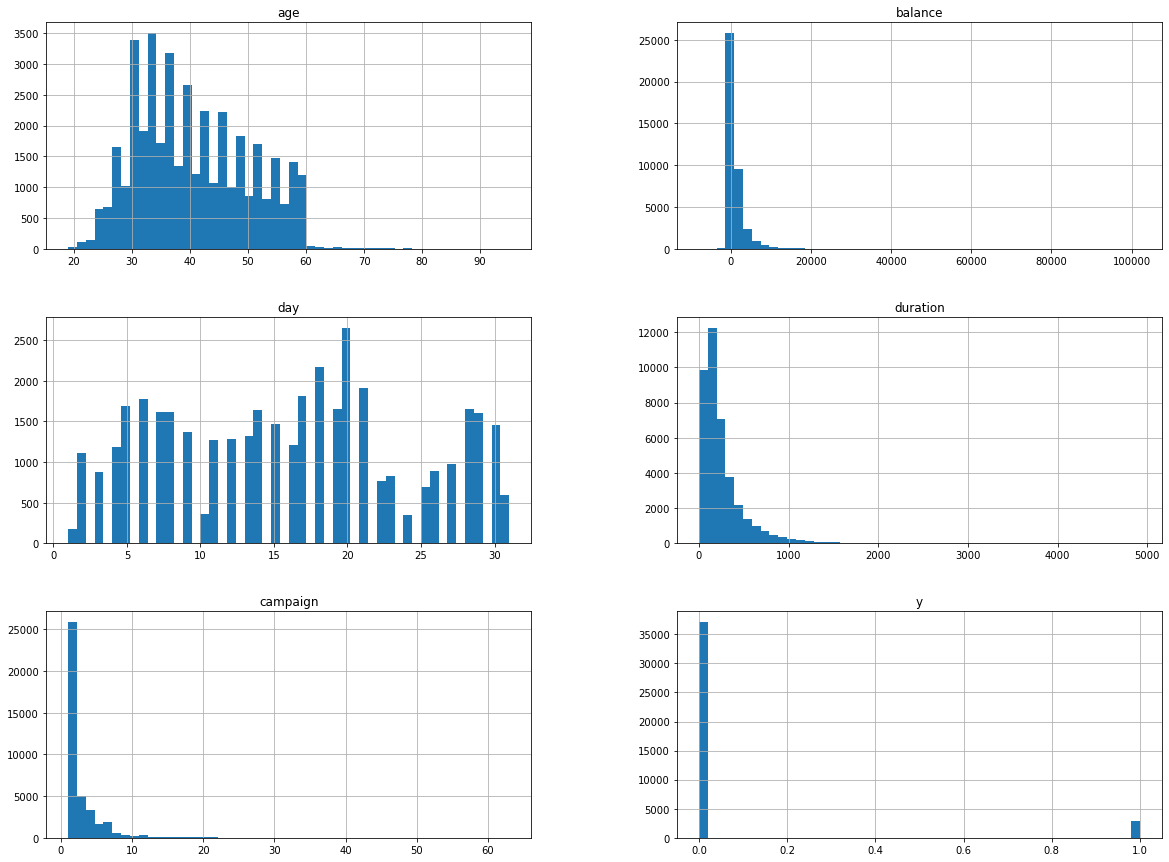

In [20]:
_ = df.hist(bins=50, figsize=(20,15))

In [21]:
#Use SMOTE to oversample the minority class
oversample = SMOTE()
over_X, over_y = oversample.fit_resample(X, y)

In [22]:
over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y, test_size=0.1, stratify=over_y)

In [24]:
#Build SMOTE SRF model
SMOTE_SRF = RandomForestClassifier(n_estimators=150, random_state=0)
#Create Stratified K-fold cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scoring = ('f1', 'recall', 'precision')

In [25]:
#Evaluate SMOTE SRF model
scores = cross_validate(SMOTE_SRF, over_X, over_y, scoring=scoring, cv=cv)

In [26]:
#Get average evaluation metrics
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))

Mean f1: 0.959
Mean recall: 0.931
Mean precision: 0.989


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


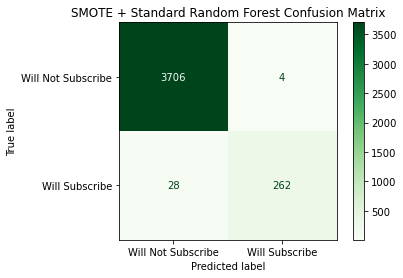

In [27]:
#Randomly spilt dataset to test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
#Train SMOTE SRF
SMOTE_SRF.fit(over_X_train, over_y_train)
#SMOTE SRF prediction result
y_pred = SMOTE_SRF.predict(X_test)
#Create confusion matrix
fig = plot_confusion_matrix(SMOTE_SRF, X_test, y_test, display_labels=['Will Not Subscribe', 'Will Subscribe'], cmap='Greens')
plt.title('SMOTE + Standard Random Forest Confusion Matrix')
plt.show()

In [31]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]

In [29]:
importances = SMOTE_SRF.feature_importances_
std = np.std([tree.feature_importances_ for tree in SMOTE_SRF.estimators_], axis=0)

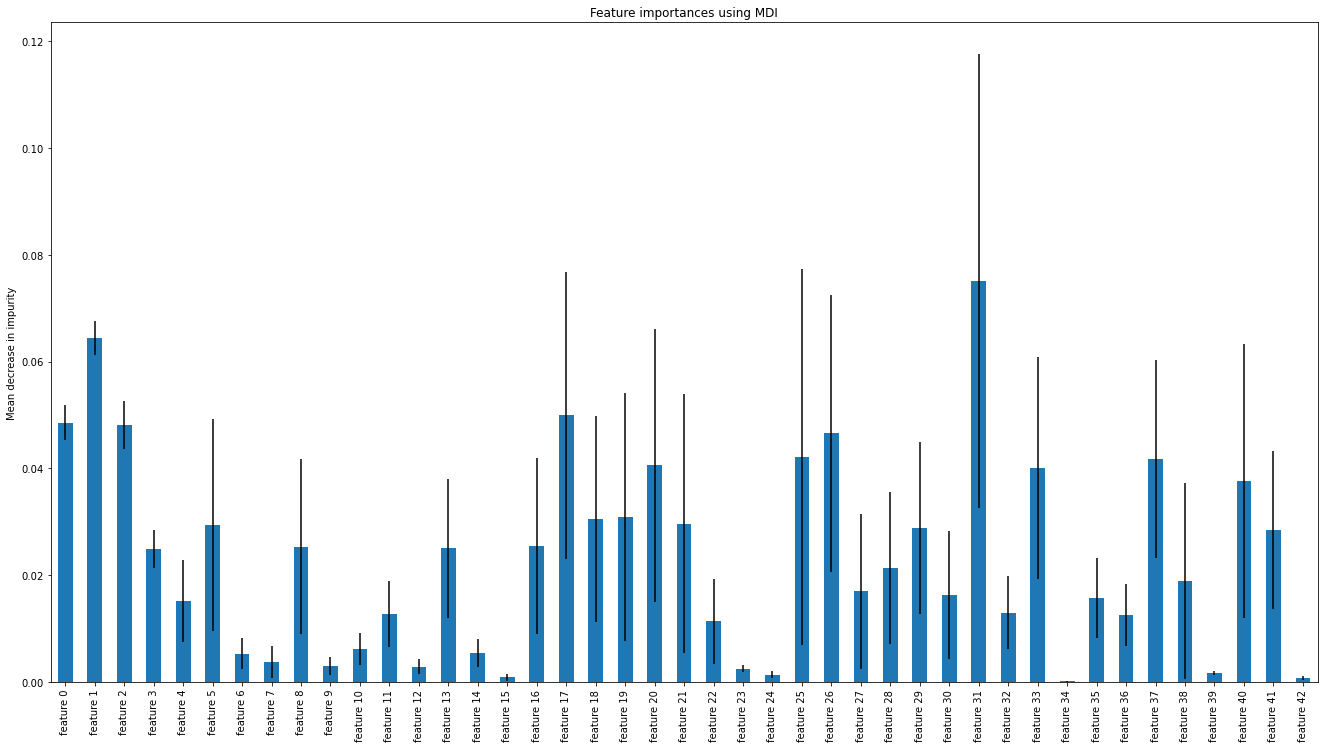

In [33]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [34]:
print(X.columns)

Index(['age', 'balance', 'day', 'campaign', 'job_admin', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married',
       'marital_single', 'education_primary', 'education_secondary',
       'education_tertiary', 'education_unknown', 'default_no', 'default_yes',
       'housing_no', 'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct'],
      dtype='object')


For the above graph, top 5 important features are: 
0 = Age,
1 = Balance (average yearly balance, in euros),
2 = Day (last contact day of the month),
17 = Marital_married
31 = Contact_telephone

In [ ]:
# this didn't work and kept loading in the background
# explainer = shap.TreeExplainer(SMOTE_SRF)
# shap_values = explainer.shap_values(over_X_test)

In [ ]:
# shap.summary_plot(shap_values, over_X_test, plot_type="bar")

In [ ]:
# shap.summary_plot(shap_values, over_X_test)